# Assignment 1 - Sentiment Analysis

#Purpose: What can the public opinion on Twitter tell us about the Canadian political landscape in 2015?

#Deniz Jafari 

In [1]:
# import needed modules 
import pandas as pd
from pandas import DataFrame
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

!pip install wordcloud
import html
import collections
from collections import Counter
from wordcloud import WordCloud 
import operator


# Part A: Data Import and Cleaning 


First both classified and unclassified data are read as dataframes

Second tweets are cleaned in the following mannor
1) Html character codes are replaced with an ASCII equivalent
2) All html tags and attributes are removed 
3) all URLs are removed
3*) remove degits as they make the classified data very noisy 
4) all characters in the text are lowercase and hashtags are removed
5) extra white spaces are removed
5) tweets are tokenized and stop words are removed

In [2]:
#Read necessary data files

#read unclassified tweets file
unclassified = open('unclassified_tweets.txt')
lines = unclassified.readlines()

unclassified_tweets = []
for line in lines:
    # get rid of the end of the line character
    line = line.rstrip(" \n ")
    # get rid of the empty lines
    if line != "":
        unclassified_tweets.append(line)
# get rid of \ufeff 
unclassified_tweets[0] = unclassified_tweets[0].strip("\ufeff") 

# put the unclassified tweets into dataframe
unclassified = DataFrame(data = unclassified_tweets, index = range(len(unclassified_tweets)),
                        columns = ['text'])

In [3]:
# read the classifed tweets into a dataframe 
classified = pd.read_csv('classified_tweets.txt', header = 0,
                         names=["class","id","date","query","user","text"])


In [4]:
# read the stop words file 
f = open('stop_words.txt')
lines = f.readlines()
stop_words = []
for l in lines:
    l = l.rstrip('\n')
    stop_words.append(l)
# import english stop words from python lib to expand the stop word file
stop = stopwords.words('english')
full_stop = stop
# combine the two stop words 
# in visualization step I realized that the classified tweets weren't clean enough
# so I decided to make the data more clean by combining two stop words as I checked the
# files and although mostly the same, both have some new words

# data further such as "ur"
full_stop.extend(x for x in stop_words if x not in full_stop)
#in visualization step I saw alot of # and @, so I decided to add them the stop word to remove
# I didn't want to add them to the punc as I wanted for hastags and users to stay as one word
# during the tokenization step 
# furhter more I added some stop words myself that I saw having a high count in later steps
# but werent part of the stop word initially, these words are used often in texting 
full_stop.extend(['@','#', 'ur', 'its','ive', 'aka', 'ldk'])
# remove words that actually result in the negative sentiment, but are considered stop words
takeout = ['cant', 'dont', 'cannot', 'hasnt', 'doesnt', 'havent','no', 'not'] 
for w in takeout:
    if w in full_stop:
        full_stop.remove(w)

In [5]:
# html character cleaning
def dfstriphtml(df):
    def striphtml(data):
        # html character codes are replaced with an ASCII equivalent
        data = html.unescape(data)
        # remove html tags
        p = re.compile(r'<.*?>')
        q = re.compile(r'<[^>]+>')
        data = p.sub('', data)
        data = q.sub('', data)
        return data
    df['text'] = df['text'].apply(striphtml)
    return df

# remove links and hyperlinks from tweets
def dfremovelinks(df):
    def removelinks(data):
        # remove website links in the form of  http\\:www.abc.com
        data = re.sub(r"http\S+", "", data)
        # remove hyperlinks with format such as 'pic.twitter.com/ppmg9ccfhq' 
        test = re.compile (r'[a-z]*[:.]+\S+')
        data = test.sub(' ', data)
        return data
    df['text'] = df['text'].apply(removelinks)
    return df

#BONUS
# in the visualization step I saw a lot of numbers as the most frequent ooccuring words
# so for the sentiment analysis I decided to remove them 
# the side effect is the removal of 4 which is often used instead of "for"
# and removal of 2 used instead of "to"
# the only place that this matters is when related to potical landscape 
# for hashtags such as elxn42 that becomes elxn
# tm4pm becomes tmpm and ready4change becomes readychange 
# knowing this, we can adjust the input of the partyindicator dictionary when trying to
# label the party of the tweet in unclassified data 
def dfremovedigit(df):
    def removedigit(data):
        result = ''.join([i for i in data if not i.isdigit()])
        return result
    df['text'] = df['text'].apply(removedigit)
    return df

#remove all the punctuations except for # and @ 
# @ and # are preserved in tweeets to detect user tag and hashtags
def dfremovepunc(df):
    def removepunc(data):
        punc = '''!()-’[]{};:'"\,<>./?$%^&*_~…+�`='''
        tweet= "".join(l for l in data if l not in punc)
        return tweet
    df['text'] = df['text'].apply(removepunc)
    return df

# remove the additional white spaces 
#make the tweet words all lower case and remove hashtags 
# this will make sure that hashtags are removed correctly 
# for example #life#good becomes life good and not lifegood
def dfremovehashtag(df):
    def removehashtag(data):
        #make data lower case
        data = data.lower()
        #Remove additional white spaces
        data = re.sub('[\s]+', ' ', data)
        #remove hashtags
        data = re.sub(r'#([^\s]+)', r'\1', data)
        return data
    df['text'] = df['text'].apply(removehashtag)
    return df

# tokenize the tweet into words, this function will preserve the user tags ex @Deniz
# stop words are removed 
def dfclean(df):
    def tweetclean(data):
        # convert tweets into list of words
        tknzr = TweetTokenizer()
        tokenized = tknzr.tokenize(data)
        filtered_tweet = list()
        for w in tokenized:
            #check to see that w is not a stop word 
            # ppl_names is the bonus section, where english common names are taken out 
            if w not in full_stop:
                filtered_tweet.append(w)
        tweet = " ".join(filtered_tweet)      
        return tweet
    df['text'] = df['text'].apply(tweetclean)
    return df

In [6]:
# cleaning classified data 
classified = dfstriphtml(classified)
classified = dfremovelinks(classified)
classified = dfremovedigit(classified)
classified = dfremovepunc(classified)
classified = dfremovehashtag(classified)
classified = dfclean(classified)
classified.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,@switchfoot awww bummer shoulda david carr thi...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting cry result ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan dived times ball managed save rest b...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,body feels itchy fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,@nationwideclass no not behaving mad cant


In [7]:
# Cleaning unclassified data
unclassified = dfstriphtml(unclassified)
unclassified = dfremovelinks(unclassified)
unclassified = dfremovedigit(unclassified)
unclassified = dfremovepunc(unclassified)
unclassified = dfremovehashtag(unclassified)
unclassified = dfclean(unclassified)
unclassified.head()

,text
0,living dream cameraman camera cameraception ca...
1,justin trudeaus reasons thanksgiving todays mo...
2,@themadape butt allergic latex sneeze nbpoli c...
3,massive explosions peace march turkey killed t...
4,mulcair suggests bad blood trudeau readychange...


# PartB: Explatory Analysis

The following steps are taken in the section to draw some insight from the classified and 
unclassified datasets 
1. The political party of a given tweet is determined in the unclassified data.
    In order to do so, a dictionary was built using the most common hashtags, names, and 
    party slogans/catch word used during the election by each party
    Depending on the presence of such words in the tweet, the tweet is categorized as either
    Liberal, Conservative, NDP, or other. The total number of the tweets per party was then       plotted. Counter was used to create a frequency dic of the words used in the tweets of         each party and Wordclouds were used to draw the most occuring ords in each party. Some         insights were drawn from visualizing these data.

2. For Classifed dataset, CountVectorizer was used to draw 5000 features from the positive
    label tweets and 5000 features from the negative lable tweets, and count the frequency of
    these futhures in the all same label data. Wordclouds were then used to visualize the most
    frequenty used words in each positive and negative label.  


In [8]:
#classify the unclassfied data set based on the polical parties

# salve the tokenized clean words into a new column called tokenized
#strip_handles gets rid of @deniz which we dont want to be True since we are 
#intested in words such as @pmharper
#reduce_len reduces the length on reduntant letters in a word to max of three
# ex is tokenizing awwwwwwww as awww, this helps with reducing the size of the counter
tknzr = TweetTokenizer(strip_handles=False, reduce_len=True)
# tokenize the tweets and store the list of words in a new column of df called 'tokenized'
unclassified['tokenized'] = unclassified.apply(lambda row: tknzr.tokenize(row['text']), axis=1)

# create a list of the most common key words used for each of the polical parties
# remeber we got rid of digits so tm4pm needs to be saved as tmpm and 
# ready4change needs to changed to readychange
liberal = ['justin','trudeau', 'trudeaus','justintrudeau','change', 'realchange','liberal','lpc','@justintrudeau']

conservative = ['stephen','harper','stephenharper','economy','conservative','cpc','@pmharper']

ndp = ['tom', 'mulcair', 'tommulcair', 'tmpm', 'readychange','dream', 'ndp', '@thomasmulcair']

other = ['green', 'elizabeth', 'may', 'elizabethmay', 'climate', 'gpc', 'bq']

polican_parties = {'Liberal':liberal,'Conservative':conservative,'NDP':ndp,'Other':other}

# this fuction categorizes tweets into either liberal, conservative, ndp, or other party
def partyindicator(data):
    # weight of a tweet being associated with each party is set to zero
    party_values = {'Liberal':0,'Conservative':0,'NDP':0,'Other':0}
    # obtain a dic with tokenized words as keys and freq in the tweet as values
    count = Counter(data)
    # loop through each word in the tweet and see if matches any of the party key words
    for word in count.keys():
        for (key,value) in polican_parties.items():
            #if found a match increase the party weight by the freq of the word
            if word in value:
                party_values[key] += count[word]
    # if the weights are all zero categorize the tweet as other 
    if all(value == 0 for value in party_values.values()):
        party = 'Other'
    else:
        #find the max value to determine the party of the tweet
        # note that if two parties have the same value, only one is returned
        party = max(party_values, key = lambda key: party_values[key])    
    return party

# save the party of the tweet into new column in df
unclassified['party'] = unclassified.apply(lambda row: partyindicator(row['tokenized']), axis=1)
unclassified.head()

,text,tokenized,party
0,living dream cameraman camera cameraception ca...,"[living, dream, cameraman, camera, cameracepti...",NDP
1,justin trudeaus reasons thanksgiving todays mo...,"[justin, trudeaus, reasons, thanksgiving, toda...",Liberal
2,@themadape butt allergic latex sneeze nbpoli c...,"[@themadape, butt, allergic, latex, sneeze, nb...",Other
3,massive explosions peace march turkey killed t...,"[massive, explosions, peace, march, turkey, ki...",Other
4,mulcair suggests bad blood trudeau readychange...,"[mulcair, suggests, bad, blood, trudeau, ready...",NDP


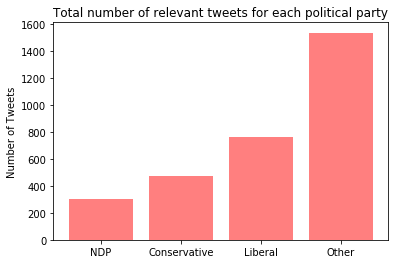

In [9]:
# get the total number of tweets per party 
ptc = unclassified.groupby(['party']).count()
# sort the total number of tweets from lowest to highest 
ptc = ptc.sort_values(by=['text'])


# visualizing the data for unclassified tweets 
x_pos = list(range(len(ptc.index)));
plt.bar(x_pos,
        # using the data from the mean_values
        ptc['text'], 
        # aligned in the center
        align='center',
        # with color
        color='red',
        # alpha 0.5
        alpha=0.5)

# set axes labels and title
plt.ylabel('Number of Tweets')
plt.xticks(x_pos, ptc.index)
plt.title('Total number of relevant tweets for each political party')
plt.show()


This plot shows that the most of the tweets can't be classified and fall into the other category. The other category infact contains tweets from minor Canadian parties as well as general election tweets that are not relevant to any specific polical party. Furthermore, other also contain data that has nothing to do with the Canadian election, but were captured in the tweet dataset due to it being about politics and\or election in some other part of the world. For example, there were few tweets with regards to the UK priminister that fell into the other category (these insights were obtained previously by looking at the wordcloud of the other category as well as the counter.most_common). Liberal party then seems to have the most number of tweets followed by Conservative and then the NDP party.

In [10]:
# return a counter that includes the words in each tweet and their total number of occurance
def wordcount(tweet):
    count = Counter(tweet)
    return count

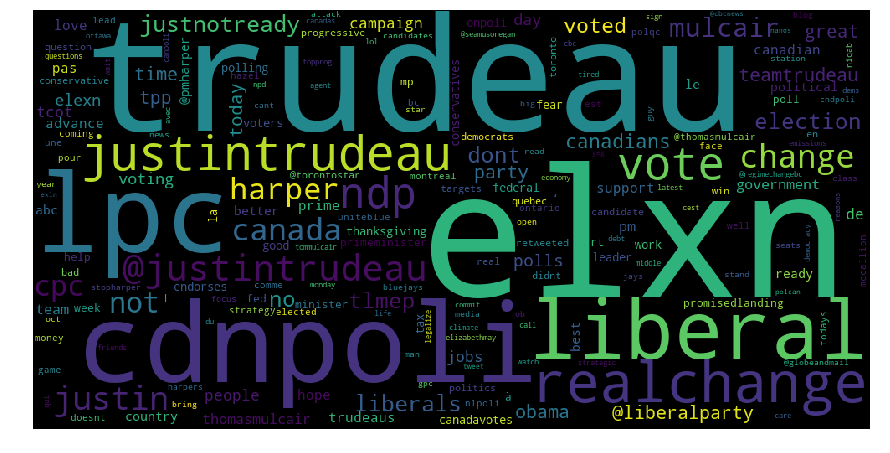

In [11]:
# seperate the data into only the lib and create a total words counter 
# this counter has all the words used in all the tweets categorized as liberal 
# as well as the number of times words apprear, this is used to create a wordcloud
lib = unclassified[unclassified['party'] == 'Liberal']
lib_counter = lib.apply(lambda row: wordcount(row['tokenized']), axis=1 ).sum()
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(lib_counter)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#in order to see the most common 25 words for liberal party, uncomment the next line 
#lib_counter.most_common(25)


It can be seen that the words that have been hard coded into the Liberal dictionary are the most frequent words seen in the liberal wordcloud. In addition, two common words are most frequently used "elxn" and "cdnpoli:, which are actually hashtags #elxn42 and #cdnpoli, which stand for 42nd election, and Canadian politics. 

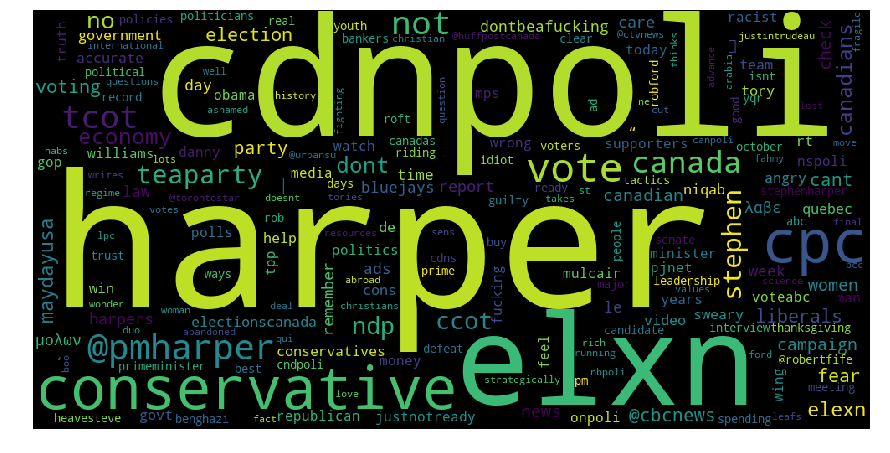

In [12]:
con = unclassified[unclassified['party'] == 'Conservative']
con_counter = con.apply(lambda row: wordcount(row['tokenized']), axis=1 ).sum()
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(con_counter)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#in order to see the most common 25 words for conservative party, uncomment the next line
#con_counter.most_common(25)

As expected, with conservative party, the hard coded conservative dictionary words also are the most frequently occuring words. Its is interesting to see that the "elxn" appears smaller compared to the liberal party. 

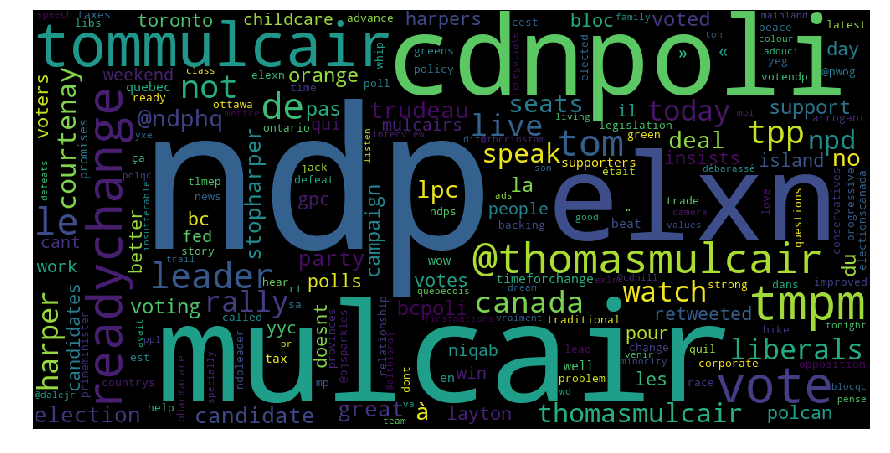

In [13]:
ndp = unclassified[unclassified['party'] == 'NDP']
ndp_counter = ndp.apply(lambda row: wordcount(row['tokenized']), axis=1 ).sum()
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(ndp_counter)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#in order to see the most common 25 words for NDP party, uncomment the next line
#ndp_counter.most_common(25)

Again, with NDP party, the hard coded conservative dictionary words also are the most frequently occuring words. Its is interesting to see that the #tm4pm and #ready4change coommon hashtags for this party appear as "tmpm" and "readychange" due to the steps taken in the data cleaning sections. 

In [14]:
# visualizing the data for classified tweets
# import the needed module for extracting features 
from sklearn.feature_extraction.text import CountVectorizer

# tokenize the tweets into list of words, this fuction is to be fed into CountVectorizer
def tokenizer(tweet):
    #reduce_len replaces repeated character sequences of length 3 or greater with sequences
    #of length 3. Strip_handles gets rid of the usernames suh as @Deniz
    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
    token = tknzr.tokenize(tweet)
    return token

# divide the data into positive and negative data depending on the labelled sentiment value
neg_class = classified[classified['class'] == 0]
pos_class = classified[classified['class'] == 4]

###################################################################################
#BONUS 
# when extracting the features for the logistic regression model in the later sections and 
# observing the dictionary of the extracted features/words, I sa alot of common names as
# part of features, although some popular human names have positive sentiment and 
# some negative sentiment, in general common human names are neutral and 
# we can take them out of the data, except for the human names we are interested in 
# which are stephen, justin, tom, thomas 
ppl_names = pd.read_csv('yob2010.txt', names=['name', 'sex', 'births'])
ppl_names = ppl_names['name'].tolist()
for x in range(len(ppl_names)):
    ppl_names[x] = ppl_names[x].lower()
takeout = ['stephen', 'tom', 'thomas', 'justin', 'harper', 'trudeau'] 
for w in takeout:
    if w in ppl_names:
        ppl_names.remove(w)
################################################################################
# use 5000 words as features to analyze the tweets with the written tokenizer fuction
# since clean tweets are entering we dont need to feed in the stop_words, but since
# we want to get rid of the common human names, we feed in ppl names as stop words
vectorizer = CountVectorizer(analyzer = 'word', tokenizer = tokenizer, 
                             stop_words = ppl_names, max_features = 5000)

# extract the features from the negatively lableded data and store them to a dictionary 
# with features\words as keys and freq/count as words
neg_dtm = vectorizer.fit_transform(neg_class['text'].tolist())
neg_vec = neg_dtm.toarray().sum(axis=0)
neg_vocab = vectorizer.get_feature_names()
neg_dic = dict((key,value) for (key,value) in zip(neg_vocab, neg_vec))

# extract the features from the positively lableded data and store them to a dictionary 
# with features\words as keys and freq/count as words
pos_dtm = vectorizer.fit_transform(pos_class['text'].tolist())
pos_vec = pos_dtm.toarray().sum(axis=0)
pos_vocab = vectorizer.get_feature_names()
pos_dic = dict((key,value) for (key,value) in zip(pos_vocab, pos_vec))

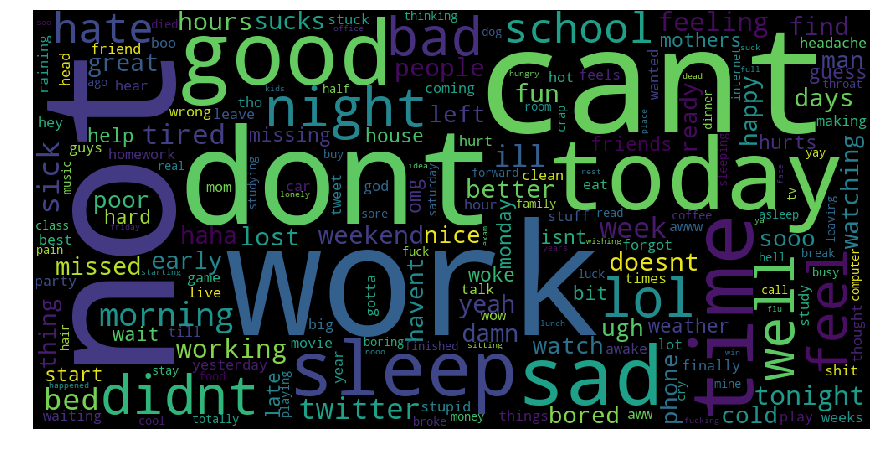

In [15]:
# create a wordcloud of the words associated with negative label
# limit the results to 200 words
wordcloud = WordCloud(width = 1000, height = 500, max_words=200).generate_from_frequencies(neg_dic)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

One can see that the most frequent words in the negatively classified tweets are "cant" (which can be result of either can't or cant as we have removed the punctuation), "dont", "work", "sad". It is intersting to see that words such as "day", "today", "good", and "lol" also appear. This words although either can be associated with either positive or negative (the first two) or be actually positive words (the last two) are still frequently occuring in the negative dataset. One possible explenation for positive words occurence is that this words often are complemented, for example, "no good", to make the overal sentiment value of a given tweet negative. However, since data is tokenized into individual words, this info is lost and we only observe the positive words by themselves in the wordcloud. 

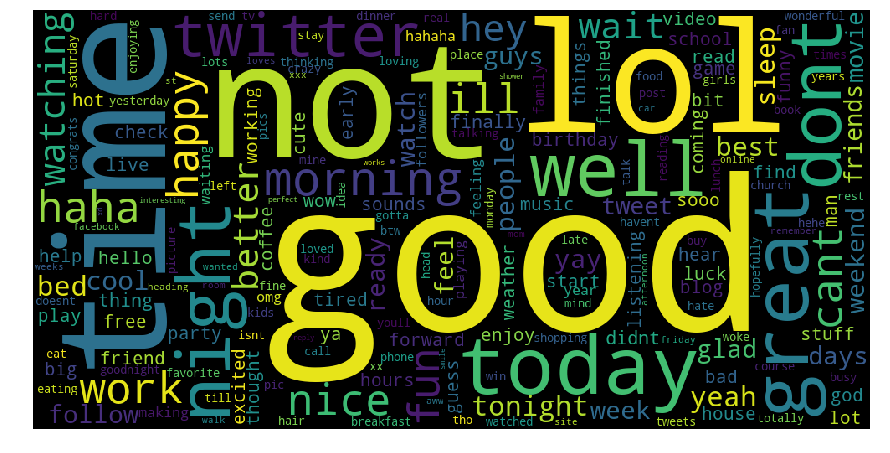

In [16]:
wordcloud = WordCloud(width = 1000, height = 500, max_words=200).generate_from_frequencies(pos_dic)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

The most occuring words in the positively associated tweets are "love", "good", "lol", "time", and "well", which are expected. 

# Model Preperation & Implementation 

Logistic regression model is prepared, evaluated, and implemented by taking the following steps:
1. The classified data is randomely split into training data (70%) and test data (30%)
2. logistic regression model is prepared
       -it is trained on the training data
       -each tweet is a single observation 
       -outcome is the sentiment value (either positive/4 or negative/0)
3. The accuracy of the model is obtained by utilizing the test data 
4. The model is then retrained on the entire classifed data
5. It is then used to evaluate the tweet sentiments in the unclassified data

BONUS1: Utilized the supplied corpus file to manually calculate the sentiment of each of the tweets in the unclassified data based on the sum of the corpus value of the words in the tweets. These obtained sentiment valeus are then compared with the logistic regression values.
BONUS2: Using cross validation to randomly select the training and testing data and calculating the accuracy and variance of the model

In [17]:
# import machine learning modules needed for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score
try:
    from sklearn.model_selection import train_test_split
except:
    from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

In [18]:

#countvectorize the features within the data
# we want the features to be common between the classifed and the unclassified data 
# vectorizer provides a sparse matrix of the feature counts in each tweet
features = vectorizer.fit_transform(classified['text'].tolist()+unclassified['text'].tolist())
# convert the features into array for ease of processing 
features_array = features.toarray()
# seperate the freq count of features for classified and unclassifed data 
X_class = features_array[:len(classified)]
X_unclass = features_array[len(classified):]
X_train, X_test, y_train, y_test = train_test_split(X_class, classified['class'] , 
                                                    train_size = 0.7, random_state=42)




/Users/denizjafari/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [19]:
# see the dictionary that contains the features 
# and the total count of features within the entire dataset, both classified and unclassifed
vec1 = features.toarray().sum(axis=0)
vocab1 = vectorizer.get_feature_names()
dic1 = dict((key,value) for (key,value) in zip(vocab1, vec1))
dic1



{'aaa': 25,
 'aaah': 69,
 'aaahhh': 29,
 'aaand': 27,
 'abandoned': 35,
 'abc': 59,
 'ability': 39,
 'abit': 31,
 'abs': 22,
 'absolute': 40,
 'absolutely': 311,
 'abt': 121,
 'ac': 65,
 'academy': 24,
 'accent': 38,
 'accept': 48,
 'accepted': 33,
 'access': 102,
 'accident': 96,
 'accidentally': 69,
 'accomplished': 41,
 'account': 299,
 'accounting': 24,
 'accounts': 58,
 'ache': 168,
 'aches': 41,
 'aching': 49,
 'ack': 32,
 'acoustic': 42,
 'acting': 98,
 'action': 111,
 'active': 39,
 'activity': 19,
 'actor': 30,
 'actress': 28,
 'actual': 68,
 'ad': 109,
 'add': 415,
 'addict': 29,
 'addicted': 122,
 'addicting': 38,
 'addiction': 55,
 'addictive': 57,
 'adding': 63,
 'addition': 23,
 'address': 77,
 'adds': 20,
 'admin': 26,
 'admit': 90,
 'adobe': 35,
 'adorable': 132,
 'ads': 81,
 'adult': 41,
 'adults': 20,
 'advance': 58,
 'advanced': 29,
 'advantage': 57,
 'adventure': 49,
 'adventures': 29,
 'advertising': 25,
 'advice': 122,
 'afford': 139,
 'afraid': 172,
 'afternoon':

In [20]:
logreg = LogisticRegression()
# train the logistic regression on the train set of the classified data 
logreg = logreg.fit(X_train, y_train)
logreg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
# predict the sentiment score of the test classified data
predict_y = logreg.predict(X_test)

In [22]:
# calculate the accuracy of the logistic regression model
accuracy = accuracy_score(y_test, predict_y)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#Show percision and recall 
# in binary classification 
# precision (also called positive predictive value) 
#is the fraction of relevant instances among the retrieved instances
# ecall (also known as sensitivity) is the fraction of relevant instances 
#that have been retrieved over the total amount of relevant instances
# explenation reference retrieved from: https://en.wikipedia.org/wiki/Precision_and_recall
print("The classification report:")
print(classification_report(y_test, predict_y))

Accuracy: 73.73%
The classification report:
             precision    recall  f1-score   support

          0       0.76      0.69      0.72     29851
          4       0.72      0.79      0.75     30149

avg / total       0.74      0.74      0.74     60000



In [23]:
# use the entire classifed dataset to train the model
logreg = LogisticRegression()
logreg = logreg.fit(X_class, classified['class'])

# use the same countvectorizer features and count the features in the unclassified data
# note that previously I used different features for unclassifed data, but I obtained the same 
# results 
#unfeatures = vectorizer.transform(unclassified['text'].tolist())
#unclassified_features_array = unfeatures.toarray()

# predict the sentiment value of the unclassified data
unclass_y_predict = logreg.predict(X_unclass)



In [24]:
# create a new dataframe and put the final unclassified data with the sentiment values in
final = pd.DataFrame(list(zip(unclass_y_predict, unclassified.text,
                              unclassified.tokenized, unclassified.party)))
final.columns = ['sentiment', 'tweet', 'tokenized','party']
dic = {0.0: 'Negative', 4.0: 'Positive'}
final['sentiment'] = final['sentiment'].map(dic)
#final.head(25)                     

In [25]:
#BONUS 

# read the supplied corpus file and create a dic
# the keys are the words in the file and the values are the sentiment values 
# which are between -5 to 5
corpus = pd.read_csv('corpus.txt',header=None,sep='\t')
corpus.columns=['word','sentiment']
corpus_dic = corpus.set_index('word')['sentiment'].to_dict()
def dfcorpus(df):
    def corpus(data):
        score = 0
        for word in data:
            if word in corpus_dic.keys():             
                score += corpus_dic[word]
        if score >= 0:
            return ('Positive')
        else:
            return ('Negative')
    df['sentiment_corpus'] = df['tokenized'].apply(corpus)
    return df

final = dfcorpus(final)
# figure out whether we have gotten the same sentiment score for each observation
# store the data into new column in the data frame and count the total values 
final['same_results']= final['sentiment']==final['sentiment_corpus']
f= final.groupby('same_results').size()
print(f)
f = (f.values[1]/(f.values[0]+ f.values[1]))*100
print('The match between two methods is %.1f%%'%(f))

same_results
False     667
True     2411
dtype: int64
The match between two methods is 78.3%


In [26]:
# BONUS 
# Use cross validation with total of cv=5 folds, which randomly seperates classified
# data into training and testing and runs logistic regression model on the data each time 
# each time the accuracy is calculated and printed in a list i.e. 5 runs of accuracy
# the average accuracy is around 73% and the low sd of 0.6%, means the data bias is low 

from sklearn import metrics, cross_validation
from sklearn.cross_validation import cross_val_score
accuracy = cross_val_score(logreg, X_class, classified['class'], cv=5,scoring='accuracy')
print (accuracy)
print ("Average accuracy: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

/Users/denizjafari/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[ 0.726925  0.738875  0.72135   0.7364    0.7317  ]
Average accuracy: 0.731%(0.006%)


# Discussion 

In order to be able to answer the research question, some visualization on data is performed. 

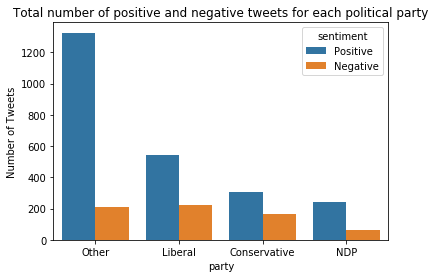

In [27]:
# first we plot the total number of tweets categorized based on their sentiment value and party
sns.countplot(x ='party', hue='sentiment', data=final, 
              order = final['party'].value_counts().index)

plt.ylabel('Number of Tweets')
plt.title('Total number of positive and negative tweets for each political party')
plt.show()

In [28]:
election_predict = final.groupby(['party','sentiment']).size()
f = election_predict.values
conservative_ratio = (f[1]/(f[0]+f[1]))*100
liberal_ratio = (f[3]/(f[2]+f[3]))*100
ndp_ratio = (f[5]/(f[4]+f[5]))*100
print('The ratio of positive to negative tweets for Liberal party is %.1f%%'%(liberal_ratio))
print('The ratio of positive to negative tweets for Conservative party is %.1f%%'%(conservative_ratio))
print('The ratio of positive to negative tweets for NDP party is %.1f%%'%(ndp_ratio))

The ratio of positive to negative tweets for Liberal party is 70.7%
The ratio of positive to negative tweets for Conservative party is 65.2%
The ratio of positive to negative tweets for NDP party is 79.0%


The above plot and the calculated ratios show that all parties have more positively associated tweets than negative. We can see that most poeple share positive views in their tweets and all parties have higher ratio of positive tweets associated with them. We can see that conservative party as the highest negative tweets associated with it. 

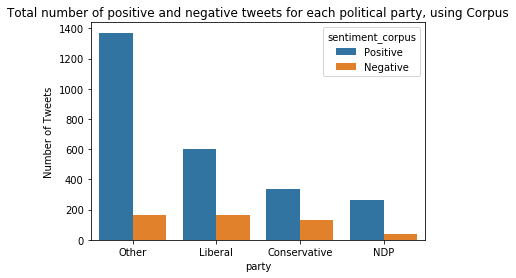

In [29]:
# Bonus, using the corpus to calculate the sentiment of tweets instead of classified data
# used the corpus file to detect the sentiment instead of the classified file
# by adding the score of the corpus words used in tweet to calculate the final 
#tweet score
sns.countplot(x ='party', hue='sentiment_corpus', data=final, 
              order = final['party'].value_counts().index)

plt.ylabel('Number of Tweets')
plt.title('Total number of positive and negative tweets for each political party, using Corpus')
plt.show()

The above plot shows that using the Corpus file instead of the classified data results in
higher rate of positively associated tweets in all of the categories. 

### Predicting the election result

from https://en.wikipedia.org/wiki/Results_of_the_Canadian_federal_election,_2015
we can obtain the % of the votes that were given to each of the parties.
There are Liberal: 39.5% Conservative: 31.9% NDP: 19.7%
Here I will be calculate the % of the positive tweets for each of the political parties and see how close these percentages are relative to the actual election voting percentages.
The rational being that ppl who want to vote for a party, tend to post positive tweets. 
In order to make the prediction, I will use the data obtained using the logistic regression model.

The percentage of positive tweets for Liberal party is 49.6%
The percentage of positive tweets for Conservative party is 28.2%
The percentage of positive tweets for NDP party is 22.2%


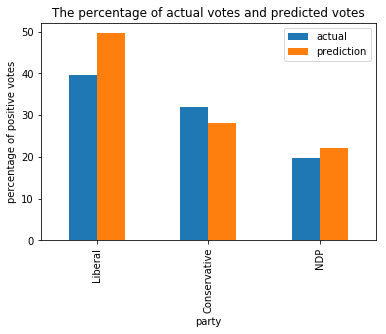

,actual,prediction
party,,
Liberal,39.5,49.632353
Conservative,31.9,28.216912
NDP,19.7,22.150735


In [30]:
positive = f[1]+ f[3] + f[5]
conservative = (f[1]/positive)*100
liberal = (f[3]/positive)*100
ndp = (f[5]/positive)*100
print('The percentage of positive tweets for Liberal party is %.1f%%'%(liberal))
print('The percentage of positive tweets for Conservative party is %.1f%%'%(conservative))
print('The percentage of positive tweets for NDP party is %.1f%%'%(ndp))

predic = [liberal, conservative, ndp]
actual = [39.5, 31.9, 19.7]
part = ['Liberal', 'Conservative', 'NDP']
compare = pd.DataFrame({'actual':actual,'prediction':predic,'party':part},
                       columns=['actual', 'prediction', 'party'])

compare = compare.set_index('party')
compare.plot.bar()

# set axes labels and title
plt.ylabel('percentage of positive votes')

plt.title('The percentage of actual votes and predicted votes')
plt.show()
compare.head()

The visualization shows that using the positive tweets to predict the vote for each party by assuming that these two variables have direct relationship results in over estimating the vote count for both Liberal and NDP and underestimates it for conservative party. The obtained prediction values are very close to the true values for conservative and ndp party, while highly overestimates the % of votes for liberal party. We can see that overal liberal party had higher positive association and public view. 

overall, the sentiment analysis shows that all the parties have more positive tweets associated with them, but Liberal party has the highest positivity and is the winner, as it was in the real life!

In [31]:
#EXTRA
# get the ratio of positive tweets with respect to the negative tweet for each party
#create a word clould of the total most common words in each of the positive and negative
# sentiment labeled data 
neg_tweets = final[final['sentiment'] == 'Negative']
pos_tweets = final[final['sentiment'] == 'Positive']
neg_count_all = neg_tweets.apply(lambda row: wordcount(row['tokenized']), axis=1 ).sum()
pos_count_all = pos_tweets.apply(lambda row: wordcount(row['tokenized']), axis=1 ).sum()
print('The 20 most common words in the negatively labled data are:')
print(neg_count_all.most_common(20))
print('The 20 most common words in the positively labled data are:')
print(pos_count_all.most_common(20))

The 20 most common words in the negatively labled data are:
[('cdnpoli', 318), ('elxn', 281), ('lpc', 120), ('cpc', 115), ('harper', 102), ('ndp', 97), ('not', 82), ('trudeau', 71), ('election', 47), ('canada', 45), ('mulcair', 44), ('realchange', 34), ('dont', 32), ('canadian', 30), ('harpers', 30), ('justintrudeau', 29), ('no', 28), ('vote', 26), ('fed', 25), ('tpp', 23)]
The 20 most common words in the positively labled data are:
[('cdnpoli', 713), ('elxn', 614), ('retweeted', 278), ('vote', 235), ('ndp', 222), ('harper', 188), ('trudeau', 149), ('liberal', 149), ('conservative', 128), ('mulcair', 122), ('canada', 119), ('realchange', 112), ('lpc', 97), ('justintrudeau', 78), ('cpc', 63), ('@justintrudeau', 62), ('primeminister', 56), ('not', 53), ('polls', 52), ('justin', 51)]


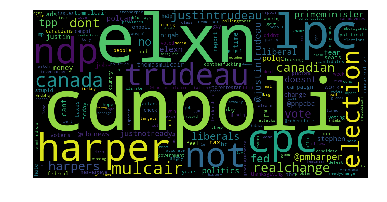

In [32]:
#create a word cloud of the most common words in the negatively labled data
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(neg_count_all)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

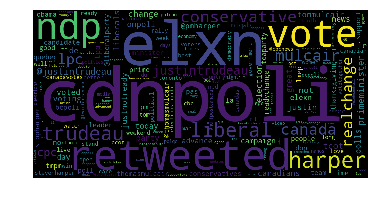

In [33]:
#create a word cloud of the most common words in the positively labled data
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(pos_count_all)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


We two wordclouds comparison shows that the positive tweets seem to be retwitted more often, hence the appearance of word "retweeted". Harper seems to be more associated with negativity, which is expected based on prior analysis performed on the sentiment data. 